In [15]:
# imports
import sys
sys.path.append('../')

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from src.load_data import master_load
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv1D, Conv2D,
                                     Dense, Dropout, Flatten, LSTM, MaxPooling1D,
                                     MaxPooling2D, Reshape, TimeDistributed)
from tensorflow.keras import regularizers
from tensorflow.math import confusion_matrix
import time


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [2]:
# set plotting params
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.labelsize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 32
plt.rcParams['figure.titlesize'] = 48

In [4]:
model_df = pd.DataFrame({'loss': [0], 'accuracy': [0], 'val_loss': [0], 'val_accuracy': [0], 'model_name': [0]})

In [5]:
def fit_model(model, X_train, y_train, X_test, y_test, epochs=5, batch_size=32, model_type='numpy'):
    global model_df
    
    fitted = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    score = fitted.model.evaluate(X_test, y_test, batch_size=batch_size)

    model_name = f'../models/{model_type}/acc_{round(score[1], 3)}-loss_{round(score[0], 2)}-{int(time.time())}.model'

    temp_df = pd.DataFrame.from_dict(fitted.history)
    temp_df['model_name'] = model_name
    model_df = pd.concat([model_df, temp_df])

    fitted.model.save(model_name)
    print('done')

In [6]:
# load image data
train_l_paths = glob('../img/data/train/left/*')
train_n_paths = glob('../img/data/train/none/*')
train_r_paths = glob('../img/data/train/right/*')
test_l_paths = glob('../img/data/test/left/*')
test_n_paths = glob('../img/data/test/none/*')
test_r_paths = glob('../img/data/test/right/*')

In [7]:
def load_image(path):
    rgba_image = Image.open(path)
    rgb_image = rgba_image.convert('RGB')
    return np.asarray(rgb_image)

In [8]:
def stack_images(paths_array):
    array = []
    
    for i in paths_array:
        array.append(load_image(i))
    
    return np.array(array)

In [9]:
def combine(left, none, right):
    combined = []
    for i in left:
        combined.append([i, np.array([1, 0, 0])])

    for i in none:
        combined.append([i, np.array([0, 1, 0])])

    for i in right:
        combined.append([i, np.array([0, 0, 1])])
        
    return np.array(combined, dtype=object)

In [10]:
def load_img_data(left_train, none_train, right_train, left_test, none_test, right_test):
    left_T_images = stack_images(left_train)
    none_T_images = stack_images(none_train)
    right_T_images = stack_images(right_train)

    left_t_images = stack_images(left_test)
    none_t_images = stack_images(none_test)
    right_t_images = stack_images(right_test)
    
    train = combine(left_T_images, none_T_images, right_T_images)
    test = combine(left_t_images, none_t_images, right_t_images)
    
    np.random.shuffle(train)
    np.random.shuffle(test)
    
    X_train = []
    y_train = []
    
    X_test = []
    y_test = []

    for feature, target in train:
        X_train.append(feature)
        y_train.append(target)
    
    for feature, target in test:
        X_test.append(feature)
        y_test.append(target)
        
    X_train = np.array(X_train) / 255
    y_train = np.array(y_train)
    X_test = np.array(X_test) / 255
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

In [11]:
# load image data
X_train_img, y_train_img, X_test_img, y_test_img = load_img_data(train_l_paths, train_n_paths, train_r_paths,
                                                                 test_l_paths, test_n_paths, test_r_paths)

In [12]:
# load fft data
X_train, X_test, y_train, y_test = master_load()

In [13]:
# reshape data
X_train_reshape = X_train.reshape(-1, 16, 60, 1)
X_test_reshape = X_test.reshape(-1, 16, 60, 1)

In [50]:
# 8895/8895 [==============================] - 245s 28ms/step - loss: 0.9311 - accuracy: 0.5686 - val_loss: 1.1161 - val_accuracy: 0.4921
model = Sequential()

model.add(Conv1D(64, (5), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(128, (5), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(256, (5), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(512, (5), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(3, (16)))
model.add(Reshape((3,)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16, 64)            19264     
_________________________________________________________________
activation_32 (Activation)   (None, 16, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16, 128)           41088     
_________________________________________________________________
activation_33 (Activation)   (None, 16, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 16, 256)         

In [ ]:
fit_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, model_type='numpy')

Epoch 1/100
8895/8895 [==============================] - 231s 26ms/step - loss: 0.9788 - accuracy: 0.5067 - val_loss: 1.1723 - val_accuracy: 0.4083
Epoch 2/100
8895/8895 [==============================] - 234s 26ms/step - loss: 0.8650 - accuracy: 0.5893 - val_loss: 1.1762 - val_accuracy: 0.4309
Epoch 3/100
8895/8895 [==============================] - 255s 29ms/step - loss: 0.8315 - accuracy: 0.6107 - val_loss: 1.1491 - val_accuracy: 0.4245
Epoch 4/100
8895/8895 [==============================] - 236s 27ms/step - loss: 0.8068 - accuracy: 0.6252 - val_loss: 1.1633 - val_accuracy: 0.4354
Epoch 5/100
8895/8895 [==============================] - 221s 25ms/step - loss: 0.7934 - accuracy: 0.6330 - val_loss: 1.2734 - val_accuracy: 0.3783
Epoch 6/100
8895/8895 [==============================] - 236s 27ms/step - loss: 0.7826 - accuracy: 0.6400 - val_loss: 1.2056 - val_accuracy: 0.3970
Epoch 7/100
8895/8895 [==============================] - 202s 23ms/step - loss: 0.7819 - accuracy: 0.6395 - val_

In [ ]:
# 8895/8895 [==============================] - 32s 4ms/step - loss: 0.1760 - accuracy: 0.9299 - val_loss: 8.7883 - val_accuracy: 0.3635
model = Sequential()

model.add(Conv1D(64, (2), input_shape=X_train.shape[1:], kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Activation('relu'))

model.add(Conv1D(64, (1), kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2), padding='same'))

model.add(Conv1D(64, (1), kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2), padding='same'))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
fit_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, model_type='numpy')

In [ ]:
# 8895/8895 [==============================] - 37s 4ms/step - loss: 0.1328 - accuracy: 0.9459 - val_loss: 10.4039 - val_accuracy: 0.3583
model = Sequential()

model.add(Conv1D(128, (1), input_shape=X_train.shape[1:], kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Activation('relu'))

model.add(Conv1D(64, (2), kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=(2), padding='same'))

model.add(Conv1D(64, (1), kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=(2), padding='same'))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
fit_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, model_type='numpy')

In [32]:
def plot_conf_mat(conf_mat):
    actions = ['left', 'none', 'right']

    fig, ax = plt.subplots(figsize=(16, 9))

    ax.matshow(conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    for i, val0 in enumerate(conf_mat.T):
        for ii, val1 in enumerate(val0):
            ax.text(i, ii, f"{val1}", va='center', ha='center')

    plt.title("Action Thought")
    plt.ylabel("Predicted Action")
    plt.show()

<ipython-input-32-f83a402bc218>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+actions)
<ipython-input-32-f83a402bc218>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+actions)


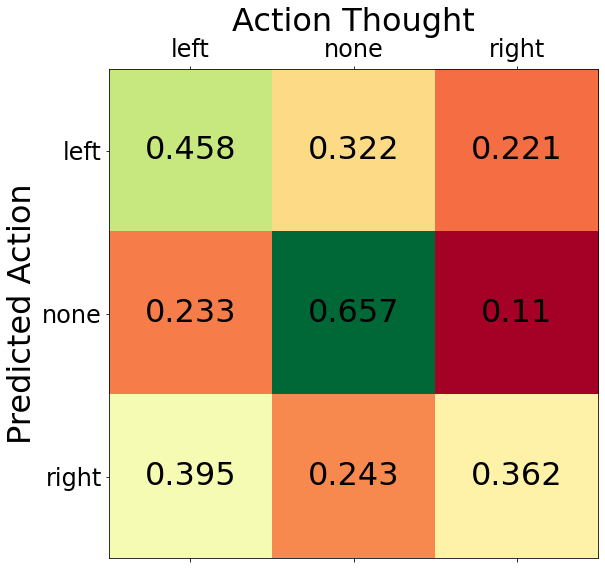

In [39]:
best_numpy_model = sorted(glob('../models/numpy/*.model'))[-1]
model_numpy = tf.keras.models.load_model(best_numpy_model)

y_pred = np.argmax(model_numpy.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
conf_mat_numpy = np.round(np.array(confusion_matrix(y_true, y_pred)) / 11750, 3)
plot_conf_mat(conf_mat_numpy)

<ipython-input-32-f83a402bc218>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+actions)
<ipython-input-32-f83a402bc218>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+actions)


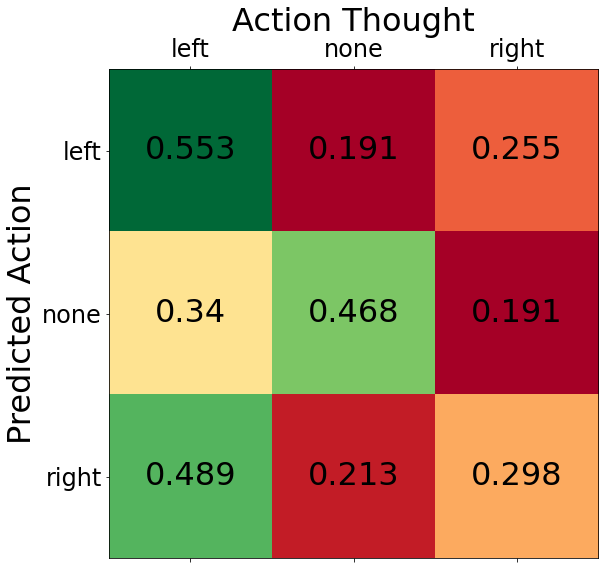

In [45]:
best_images_model = sorted(glob('../models/images/*.model'))[-1]
model_images = tf.keras.models.load_model(best_images_model)

y_pred = np.argmax(model_images.predict(X_test_img), axis=-1)
y_true = np.argmax(y_test_img, axis=-1)
conf_mat_images = np.round(np.array(confusion_matrix(y_true, y_pred)) / 47, 3)
plot_conf_mat(conf_mat_images)

# trained KNN, log_reg, GBC, LSTM, transfer learning
# all trash, acc < 0.35
# spectrograms and FFT data